In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
import matplotlib.animation as animation
import os


warnings.filterwarnings('ignore')


In [2]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [3]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [4]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [5]:
#Count the distribution of number of cells per cluster
def count_freq(g):
    clust_information=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
    a=Counter(clust_information)
    freq=list(a.values())
    return freq

In [6]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [7]:
def break_cluster_sa(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break'] and (g.edges[e[0],e[1]]['break']!=0)):
            g.edges[e[0],e[1]]['break']=0

    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            for k,bt in enumerate(edge_bt): 
                if(np.round(bt,0)>=t):
                    edge_tbb=edges[k]
                    g.edges[edge_tbb[0],edge_tbb[1]]['break']=0    

        

In [8]:
def grow_func_kn(t,mbt,max_node):
    global g
    nextg=g.copy()
    
    degree_list=[]
    node_kn=[]
    node_list=[node for node in g.nodes()]
   
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]==(max_node-1)):
            node_kn.append(node)
#     print(len(node_kn))
    for n in g.nodes():
        if(n in node_kn):
            pass
        else:
            new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
            nextg.add_edge(str(n),new_node) #Growth
            nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
            nextg.edges[str(n),new_node]['break']=1
            nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg

In [9]:
def grow(t,mbt):
    global g
    nextg=g.copy()
    for n in g.nodes():
        new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
        nextg.add_edge(str(n),new_node) #Growth
        nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
        nextg.edges[str(n),new_node]['break']=1
        nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg



In [10]:
def init_system():
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    nextg=g.copy()

In [11]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
def clust_form_and_break(sim_time,max_node,mbt,dt,h):
    global g
    
    init_system()
    
    for t in range(sim_time):
        if(int(t%dt)==0):             
            if(h==0):
                grow(t,mbt)
            else:
                grow_func_kn(t,mbt,max_node)
        
        break_cluster_sa(t,max_node)
        graph_snap(t,sim_time)
    
    module_counter()
    
    return g

### Simulations for Figure 7 (Nanda et al (2023))

#### Cluster-size distribution when $ \lambda = f(\delta) $

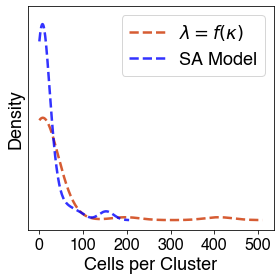

In [15]:
plt.rc('font',family='helvetica')
plt.figure(figsize=(4,4))
np.random.seed(221)
sns.kdeplot(pd.Series(count_freq(clust_form_and_break(30,8,100,3,1))),linestyle='--',linewidth=2.5,clip=(0,1000),color=(0.8,0.2,0,0.8))
sns.kdeplot(pd.Series(count_freq(clust_form_and_break(30,8,100,3,0))),linestyle='--',linewidth=2.5,clip=(0,1000),color=(0.0,0.0,1,0.8))
plt.ylim([-0.001,0.022])
plt.xlabel('Cells per Cluster',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks([],fontsize=16)
plt.legend([r'$ \lambda = f(\kappa)$','SA Model'],fontsize=18)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Fig7.png',dpi=600)